In [1]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load("validation_trace.npz")
example = data["raw"]
fit_ampl = data["ampl"]
fit_chisq = data["chisq"]
idx = data["inject"].item()  

In [2]:
idx

102823

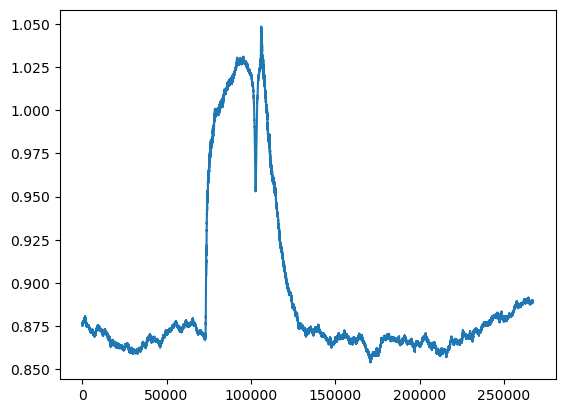

In [3]:
plt.plot(fit_chisq)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
length = len(template)

L_example = len(example)
L_temp = len(template)

template_padded = np.pad(template, (0, L_example - L_temp))
template_fft = fft(template_padded) / sampling_frequency
example_fft = fft(example) / sampling_frequency
if L_example % 2 == 0:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:-1] / 2,
        [noise_psd[-1]],
        noise_psd[-2:0:-1] / 2
    ))
else:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:] / 2,
        noise_psd[-1:0:-1] / 2
    ))
noise_psd_unfolded = np.pad(noise_psd_unfolded, (0, L_example - len(noise_psd_unfolded)))

noise_psd_unfolded = np.where(noise_psd_unfolded == 0, 1e30, noise_psd_unfolded)

kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / L_example
filter_kernel_fft = kernel_fft / kernel_normalization

filtered_fft = example_fft * filter_kernel_fft
amp_t0_global = np.real(ifft(filtered_fft)) * sampling_frequency

power_fft = example_fft.conj() * example_fft / noise_psd_unfolded
chi0_global = np.real(np.sum(power_fft)) * sampling_frequency / L_example
chit_withdelay = amp_t0_global**2 * kernel_normalization
chi2_t0_global = (chi0_global - chit_withdelay) / (L_example - 2)  # normalize by DOF


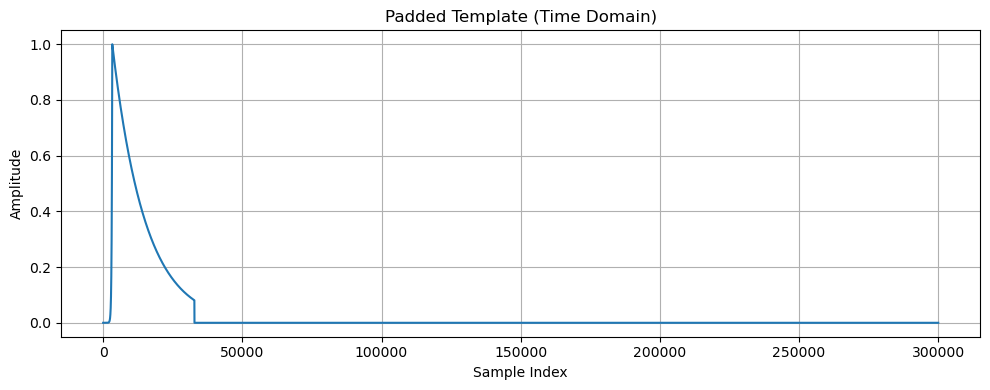

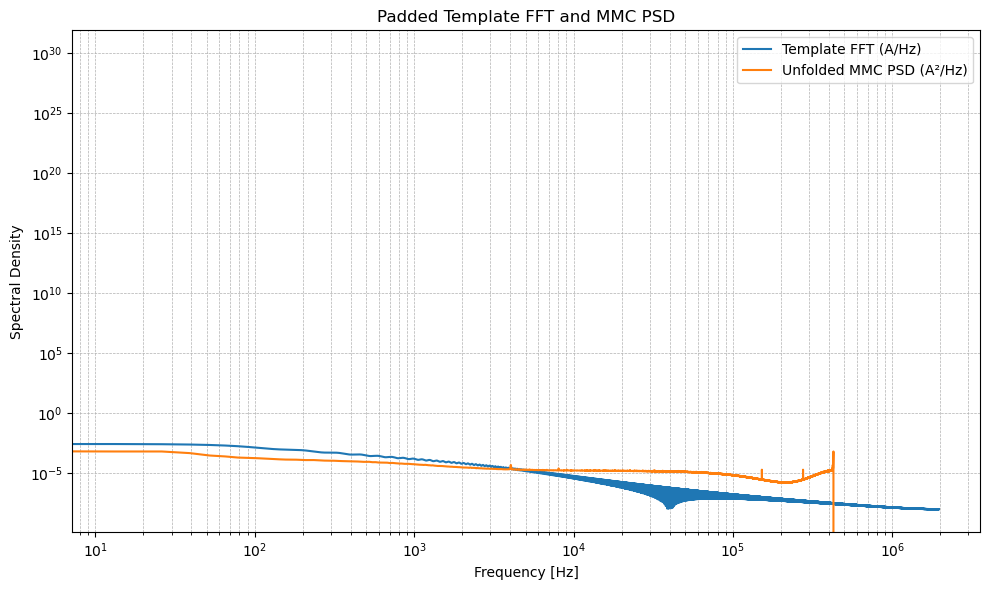

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

# === Parameters ===
template_path = "templates/sub_ch_template.npy"
psd_path = "../../templates/noise_psd_from_MMC.npy"

# === Load template and PSD ===
template = np.load(template_path)
noise_psd = np.load(psd_path)

# === Padding ===
L_example = len(example)
L_temp = len(template)

# Pad template to length of example
template_padded = np.pad(template, (0, L_example - L_temp))

# FFT
template_fft = fft(template_padded) / sampling_frequency
frequencies = fftfreq(L_example, d=1.0 / sampling_frequency)

# Unfold PSD (one-sided → two-sided), then pad
if L_example % 2 == 0:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:-1] / 2,
        [noise_psd[-1]],
        noise_psd[-2:0:-1] / 2
    ))
else:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:] / 2,
        noise_psd[-1:0:-1] / 2
    ))

# Pad to match example length
noise_psd_unfolded = np.pad(noise_psd_unfolded, (0, L_example - len(noise_psd_unfolded)))

# === Plot Padded Template (Time Domain) ===
plt.figure(figsize=(10, 4))
plt.plot(np.arange(L_example), template_padded)
plt.title("Padded Template (Time Domain)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Template FFT and Padded PSD (Frequency Domain) ===
plt.figure(figsize=(10, 6))
plt.loglog(frequencies[:L_example // 2], np.abs(template_fft[:L_example // 2]), label="Template FFT (A/Hz)")
plt.loglog(frequencies[:L_example // 2], noise_psd_unfolded[:L_example // 2], label="Unfolded MMC PSD (A²/Hz)")
plt.title("Padded Template FFT and MMC PSD")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Spectral Density")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/home/dwong/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dwong/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


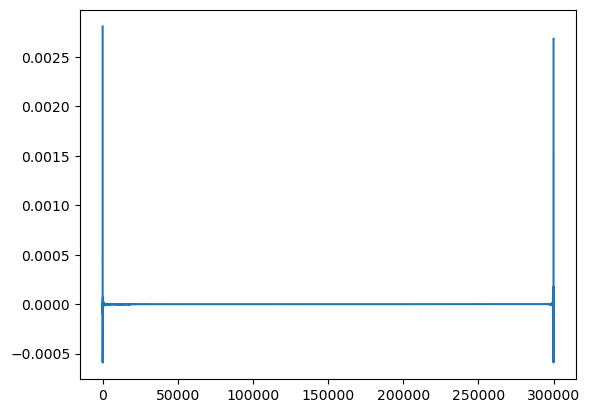

In [10]:
plt.plot(template_fft)

In [3]:
from OptimumFilter import *
sub_of = OptimumFilter(template, noise_psd, sampling_frequency)


In [4]:
a, b, c = sub_of.fit(example[-32768:])

In [13]:
fit_ampl = np.concatenate([data["ampl"], c])


In [14]:
len(fit_ampl)

50001

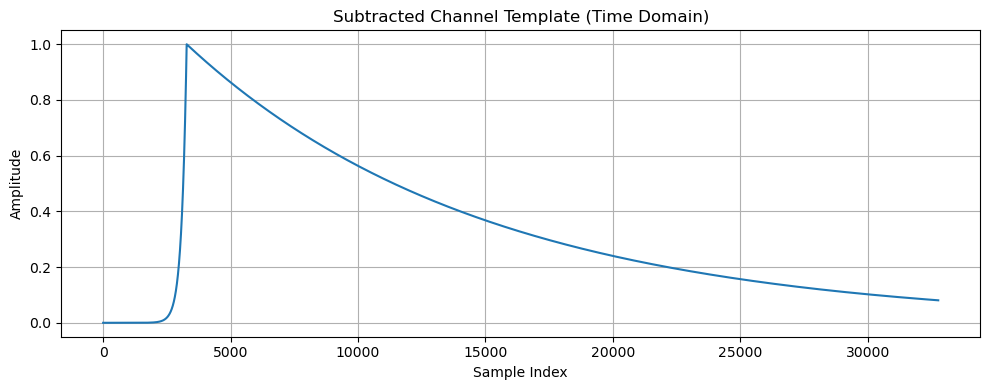

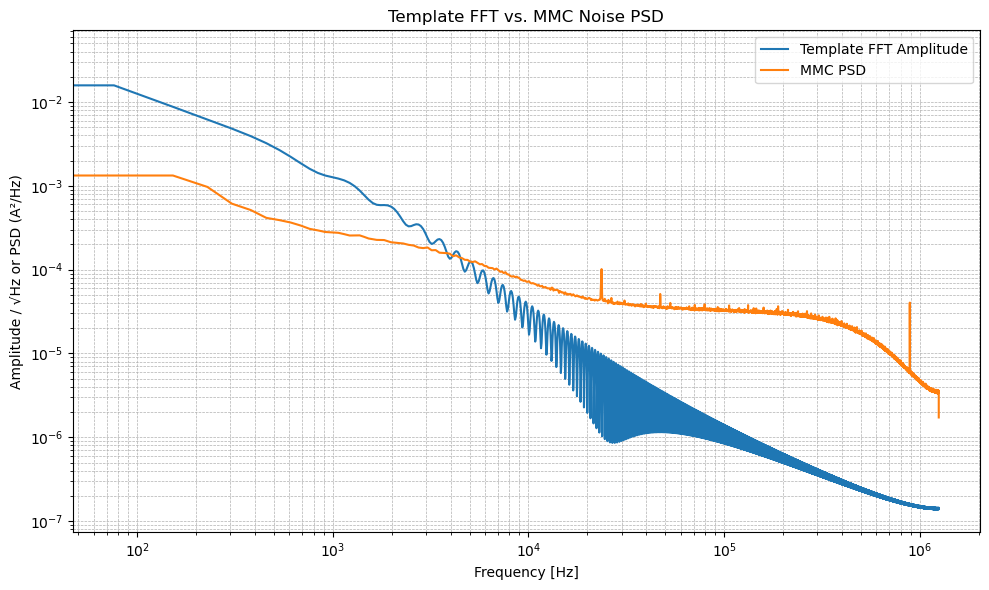

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
from scipy.interpolate import interp1d
import os

# === Parameters ===
sampling_rate = 2_500_000.0
template_path = "templates/sub_ch_template.npy"
mmc_path = "../../templates/noise_psd_from_MMC.npy"

# === Load signal template and compute amplitude spectral density ===
if not os.path.exists(template_path):
    raise FileNotFoundError(f"Signal template not found at: {template_path}")

signal = np.load(template_path)
N = len(signal)
frequencies = rfftfreq(N, d=1.0 / sampling_rate)
fft_amplitude_density = np.abs(rfft(signal)) / np.sqrt(sampling_rate * N)

# === Plot signal template in time domain (sample index) ===
plt.figure(figsize=(10, 4))
plt.plot(np.arange(N), signal)
plt.title("Subtracted Channel Template (Time Domain)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Load MMC PSD ===
if not os.path.exists(mmc_path):
    raise FileNotFoundError(f"MMC PSD not found at: {mmc_path}")

mmc_psd = np.load(mmc_path)
if len(mmc_psd) != len(frequencies):
    original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
    mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)

# === Plot both FFT and MMC PSD ===
plt.figure(figsize=(10, 6))
plt.loglog(frequencies, fft_amplitude_density, label="Template FFT Amplitude")
plt.loglog(frequencies, mmc_psd, label="MMC PSD")

plt.title("Template FFT vs. MMC Noise PSD")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude / √Hz or PSD (A²/Hz)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
np.argmin(chi2_t0_global)

12043

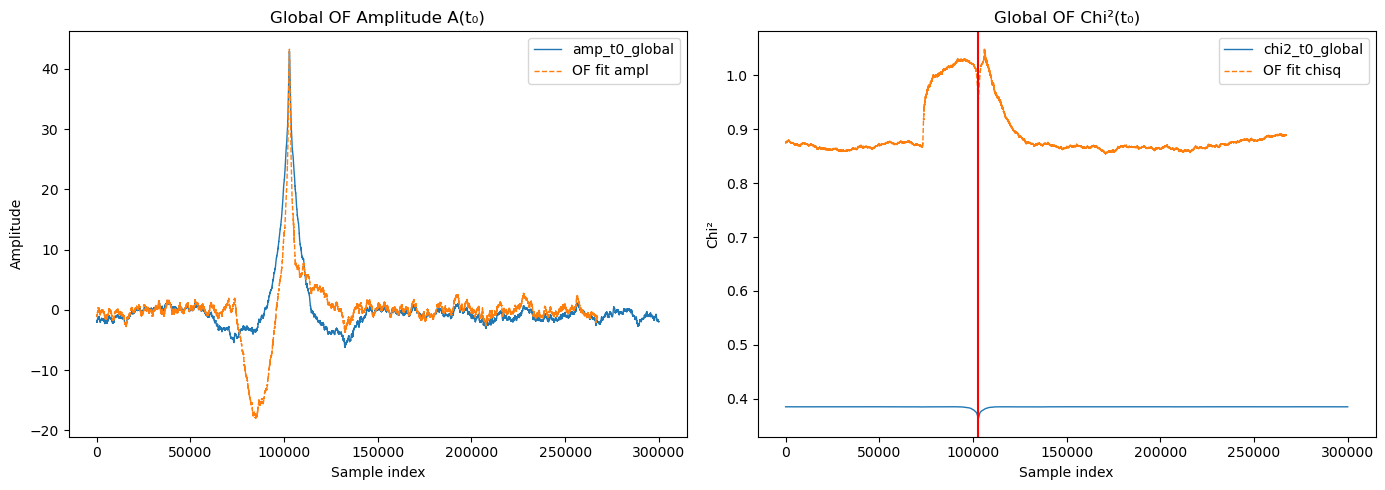

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure all arrays are the same length by padding fit outputs with NaNs
full_length = 300000

fit_ampl_padded = np.full(full_length, np.nan)
fit_chisq_padded = np.full(full_length, np.nan)

fit_length = min(len(fit_ampl), full_length)
fit_ampl_padded[:fit_length] = fit_ampl[:fit_length]

# Plot
plt.figure(figsize=(14, 5))

# Amplitude
plt.subplot(1, 2, 1)
plt.plot(amp_t0_global, label="amp_t0_global", linewidth=1)
plt.plot(fit_ampl_padded, label="OF fit ampl", linewidth=1, linestyle='--')
plt.title("Global OF Amplitude A(t₀)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.legend()

# Chi²
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_global, label="chi2_t0_global", linewidth=1)
plt.plot(fit_chisq, label="OF fit chisq", linewidth=1, linestyle='--')
plt.title("Global OF Chi²(t₀)")
plt.xlabel("Sample index")
plt.ylabel("Chi²")
plt.legend()
plt.axvline(x=102823, color='red', linestyle='-', linewidth=1.5, label=f'Index {highlight_index}')

plt.tight_layout()
plt.show()


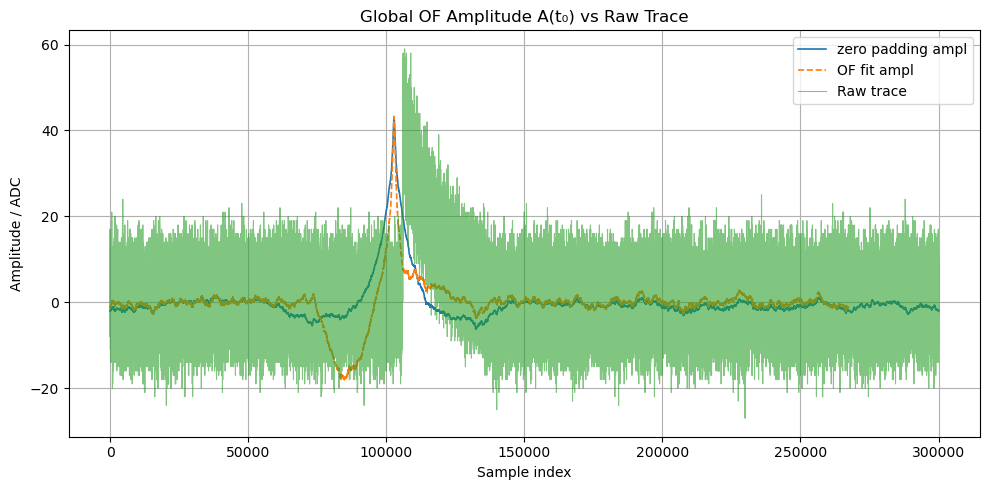

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare padded fit amplitude (in case fit_ampl is shorter)
full_length = len(amp_t0_global)
fit_ampl_padded = np.full(full_length, np.nan)

fit_length = min(len(fit_ampl), full_length)
fit_ampl_padded[:fit_length] = fit_ampl[:fit_length]

# Plot Amplitude and Raw Trace
plt.figure(figsize=(10, 5))

plt.plot(amp_t0_global, label="zero padding ampl", linewidth=1.2)
plt.plot(fit_ampl_padded, label="OF fit ampl", linewidth=1.2, linestyle='--')
plt.plot(example, label="Raw trace", linewidth=0.8, alpha=0.6)

plt.title("Global OF Amplitude A(t₀) vs Raw Trace")
plt.xlabel("Sample index")
plt.ylabel("Amplitude / ADC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


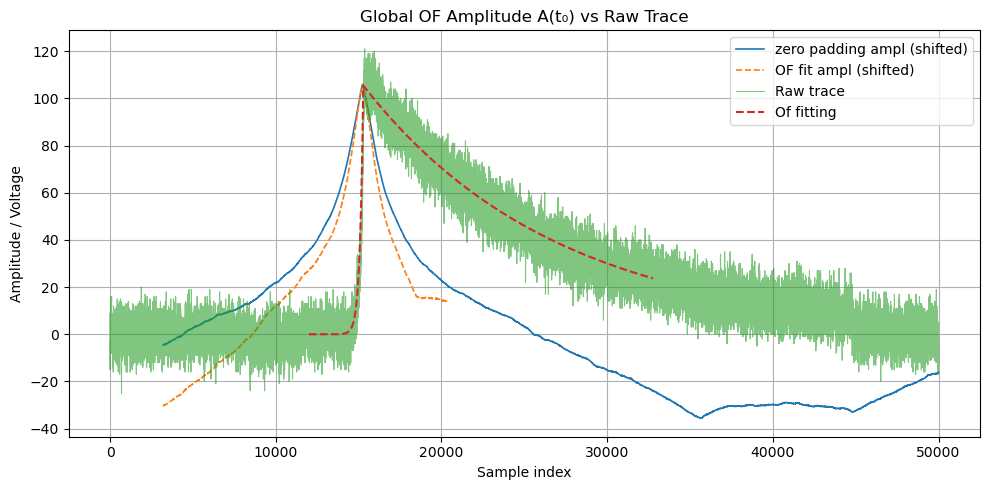

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
shift_ampl = 3200  # shift for amplitude arrays
shift_template = idx  # shift for template_scaled

# Prepare padded and shifted fit amplitude
full_length = len(amp_t0_global)
fit_ampl_padded = np.full(full_length, np.nan)
fit_length = min(len(fit_ampl), full_length - shift_ampl)  # prevent overflow
fit_ampl_padded[shift_ampl:shift_ampl + fit_length] = fit_ampl[:fit_length]

# Shift zero padding ampl
amp_t0_shifted = np.full(full_length, np.nan)
valid_length = full_length - shift_ampl
amp_t0_shifted[shift_ampl:] = amp_t0_global[:valid_length]

# Shift template
template_shifted = np.full_like(template_scaled, np.nan)
if shift_template + len(template_scaled) <= len(example):
    template_shifted = np.roll(template_scaled, shift_template)
    template_shifted[:shift_template] = np.nan  # clear wraparound
else:
    # Shift with truncation
    template_shifted = np.full_like(example, np.nan)
    max_len = len(example) - shift_template
    template_shifted[shift_template:] = template_scaled[:max_len]

# Plot everything
plt.figure(figsize=(10, 5))

plt.plot(amp_t0_shifted, label="zero padding ampl (shifted)", linewidth=1.2)
plt.plot(fit_ampl_padded, label="OF fit ampl (shifted)", linewidth=1.2, linestyle='--')
plt.plot(example, label="Raw trace", linewidth=0.8, alpha=0.6)
plt.plot(template_shifted, label=f'Of fitting', linewidth=1.5, linestyle='--')

plt.title("Global OF Amplitude A(t₀) vs Raw Trace")
plt.xlabel("Sample index")
plt.ylabel("Amplitude / Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from joblib import Parallel, delayed
import numpy as np

trace = example  # assuming example is a 1D array of length 50000
window_size = 32768
num_windows = len(trace) - window_size + 1

def fit_window(i):
    segment = trace[i:i+window_size]
    return sub_of.fit(segment)

results = Parallel(n_jobs=-1)(delayed(fit_window)(i) for i in range(num_windows))
ampl_arr, chisq_arr = map(np.array, zip(*results))

In [42]:
from OptimumFilter import *

sub_template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

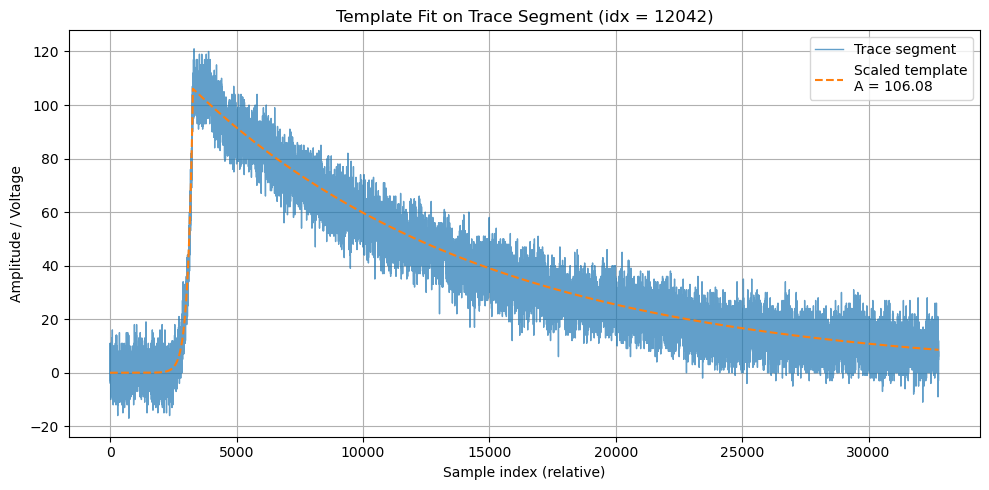

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window_length = len(template)

# Extract the segment to fit
trace_segment = example[idx:idx + window_length]

# Apply optimum filter fit
ampl_fit, chisq_fit = sub_of.fit(trace_segment)

# Rescale the template
template_scaled = ampl_fit * template

# Time axis for plotting
time = np.arange(window_length)

# Plot
plt.figure(figsize=(10, 5))

plt.plot(time, trace_segment, label='Trace segment', linewidth=1.0, alpha=0.7)
plt.plot(time, template_scaled, label=f'Scaled template\nA = {ampl_fit:.2f}', linewidth=1.5, linestyle='--')

plt.title(f"Template Fit on Trace Segment (idx = {idx})")
plt.xlabel("Sample index (relative)")
plt.ylabel("Amplitude / Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
# Around the global OF peak
t0 = np.argmax(amp_t0_global)
print("Global OF peak index:", t0)
print("Amplitudes near peak:")
for i in range(t0 - 2, t0 + 3):
    print(f"  amp_t0_global[{i}] = {amp_t0_global[i]:.6f}")


Global OF peak index: 12043
Amplitudes near peak:
  amp_t0_global[12041] = 105.347999
  amp_t0_global[12042] = 105.352014
  amp_t0_global[12043] = 105.361006
  amp_t0_global[12044] = 105.342917
  amp_t0_global[12045] = 105.340468


In [73]:
def quadratic_peak(y_minus, y_0, y_plus):
    # Fit parabola: y = a(x - x0)^2 + b
    numerator = y_minus - y_plus
    denominator = 2 * (y_minus - 2*y_0 + y_plus)
    if denominator == 0:
        return 0.0  # avoid div-by-zero
    delta = 0.5 * numerator / denominator
    return delta  # offset in samples from center (e.g., 12043 + delta)

# Use near-peak points
i_peak = np.argmax(amp_t0_global)
if 1 <= i_peak < len(amp_t0_global) - 1:
    delta = quadratic_peak(
        amp_t0_global[i_peak - 1],
        amp_t0_global[i_peak],
        amp_t0_global[i_peak + 1]
    )
    print(f"Sub-sample peak offset: {i_peak + delta:.4f}")


Sub-sample peak offset: 12042.9160


In [79]:
def print_peak_neighborhood(name, ampl_arr):
    i_peak = np.nanargmax(ampl_arr)
    print(f"\n{name} peak index: {i_peak}")
    print(f"{name} amplitudes near peak:")
    for i in range(i_peak - 2, i_peak + 3):
        if 0 <= i < len(ampl_arr):
            print(f"  {name}[{i}] = {ampl_arr[i]:.6f}")
        else:
            print(f"  {name}[{i}] = ---")

    return i_peak

def quadratic_peak(y_minus, y_0, y_plus):
    numerator = y_minus - y_plus
    denominator = 2 * (y_minus - 2*y_0 + y_plus)
    if denominator == 0:
        return 0.0  # flat region
    delta = 0.5 * numerator / denominator
    return delta  # sub-sample offset from center

# Analyze global OF amplitude
i_peak_global = print_peak_neighborhood("zero padding ampl", amp_t0_global)
if 1 <= i_peak_global < len(amp_t0_global) - 1:
    delta_global = quadratic_peak(
        amp_t0_global[i_peak_global - 1],
        amp_t0_global[i_peak_global],
        amp_t0_global[i_peak_global + 1]
    )

# Analyze sliding OF amplitude
i_peak_fit = print_peak_neighborhood("OF fit ampl", fit_ampl)
if 1 <= i_peak_fit < len(fit_ampl) - 1:
    delta_fit = quadratic_peak(
        fit_ampl[i_peak_fit - 1],
        fit_ampl[i_peak_fit],
        fit_ampl[i_peak_fit + 1]
    )



zero padding ampl peak index: 12043
zero padding ampl amplitudes near peak:
  zero padding ampl[12041] = 105.347999
  zero padding ampl[12042] = 105.352014
  zero padding ampl[12043] = 105.361006
  zero padding ampl[12044] = 105.342917
  zero padding ampl[12045] = 105.340468

OF fit ampl peak index: 12042
OF fit ampl amplitudes near peak:
  OF fit ampl[12040] = 106.076456
  OF fit ampl[12041] = 106.070753
  OF fit ampl[12042] = 106.078763
  OF fit ampl[12043] = 106.074732
  OF fit ampl[12044] = 106.044628


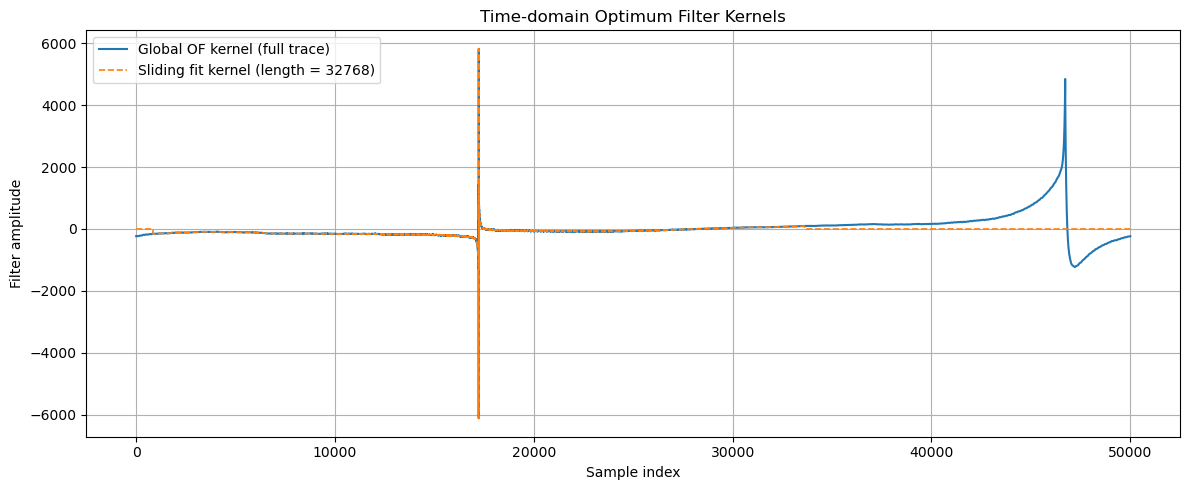

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# --- Assumptions ---
# You already have:
# - template
# - noise_psd
# - sampling_frequency
# - filter_kernel_fft (from global method)
# - length = len(trace)

# --- Time-domain global kernel ---
kernel_td_global = np.real(ifft(filter_kernel_fft)) * sampling_frequency

# --- Local (fit) kernel: truncate global kernel to match template length ---
L_temp = len(template)
center = np.argmax(np.abs(kernel_td_global))  # center of the global kernel
half = L_temp // 2
start = center - half
end = center + (L_temp - half)

# Clip for safety
start = max(start, 0)
end = min(end, len(kernel_td_global))

kernel_td_fit_like = np.zeros_like(kernel_td_global)
kernel_td_fit_like[start:end] = kernel_td_global[start:end]

# --- Plot ---
plt.figure(figsize=(12, 5))

plt.plot(kernel_td_global, label="Global OF kernel (full trace)", linewidth=1.5)
plt.plot(kernel_td_fit_like, label=f"Sliding fit kernel (length = {L_temp})", linewidth=1.2, linestyle='--')
plt.title("Time-domain Optimum Filter Kernels")
plt.xlabel("Sample index")
plt.ylabel("Filter amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Function to compute Full Width at Half Maximum (FWHM)
def compute_fwhm(signal):
    peak = np.max(signal)
    half_max = peak / 2.0
    indices = np.where(signal >= half_max)[0]
    if len(indices) > 1:
        return indices[-1] - indices[0]
    return 0

# Analyze kernels
peak_global = np.max(kernel_td_global)
fwhm_global = compute_fwhm(kernel_td_global)
peak_fit = np.max(kernel_td_fit_like)
fwhm_fit = compute_fwhm(kernel_td_fit_like)


In [25]:
peak_global

5816.869988549931

In [26]:
peak_fit

5816.869988549931

In [18]:
area_global = np.nansum(amp_t0_global ** 2)
area_fit_padded = np.nansum(fit_ampl_padded ** 2)

In [19]:
print(area_global)
print(area_fit_padded)

47641772.29572583
47734468.52511519
